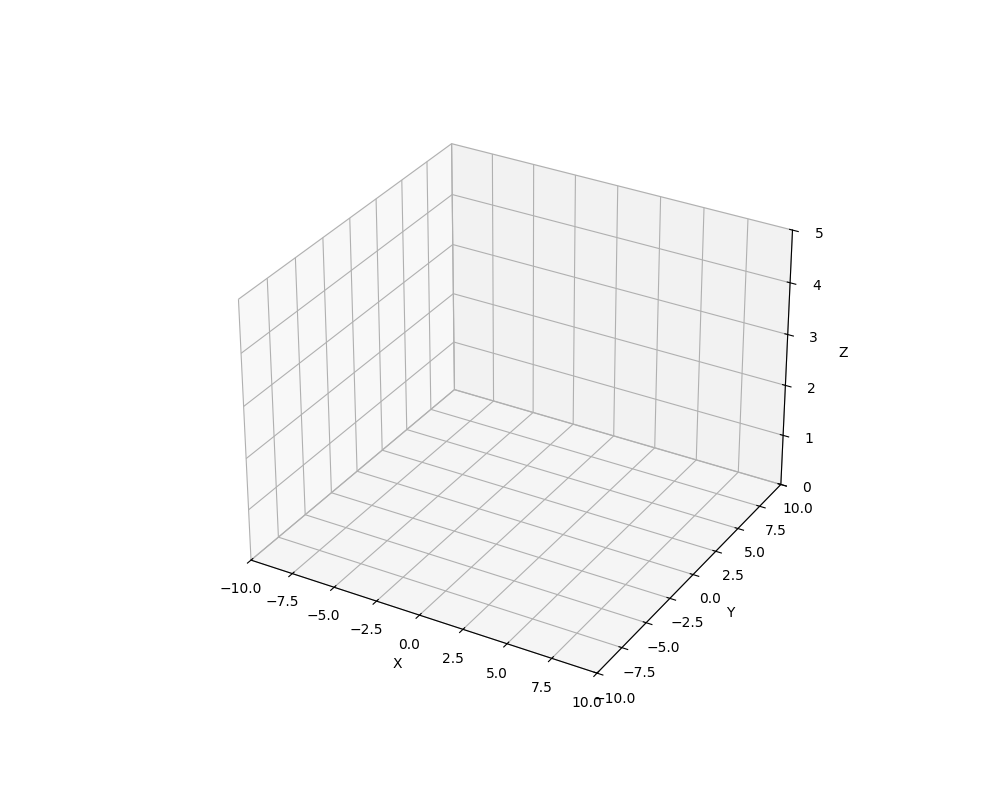

In [1]:
%matplotlib ipympl

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from scipy import linalg

# 設定
n = 11  # グリッドサイズ
frames = 40  # アニメーションフレーム数
interval = 125  # フレーム間隔
snapshot_interval_sec = 2  # スナップショット間隔

# nxnの2次元行列を作成
points = []
for i in range(n):
    for j in range(n):
        points.append([i - 5, j - 5])
points = np.array(points)

# プロット設定
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection="3d")

# 軸設定
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(0, 5)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# グリッド設定
ax.grid(True)

# スナップショットと現在のフレームの散布図を初期化
snapshots = []
snapshot_plots = []
current_scatter = ax.scatter([], [], [])

transform_matrix = np.array(
    [
        [1, 0.1],
        [0, 1],
    ]
)


# アニメーション更新関数
def update(frame):
    global snapshots, snapshot_plots, current_scatter

    msec = frame * interval

    if frame == 0:
        # 初期化
        snapshots = []
        for snapshot_plot in snapshot_plots:
            snapshot_plot.remove()
        snapshot_plots.clear()

    powered = linalg.fractional_matrix_power(transform_matrix, msec / 1000)

    # 回転行列との積を求めて点を更新
    transformed = np.dot(points, powered.T)
    transformed_x = transformed[:, 0]
    transformed_y = transformed[:, 1]
    transformed_z = [msec / 1000] * len(transformed[:, 0])

    # 1秒ごとにスナップショットを追加
    if msec % (1000 * snapshot_interval_sec) == 0:
        snapshots.append((transformed_x, transformed_y, transformed_z))
        snapshot_plot = ax.scatter(
            transformed_x, transformed_y, transformed_z, color="green", alpha=0.25
        )
        snapshot_plots.append(snapshot_plot)

    # 現在のフレームの散布図を更新
    current_scatter._offsets3d = (transformed_x, transformed_y, transformed_z)

    # すべてのプロットオブジェクトを返す
    return tuple(snapshot_plots + [current_scatter])


# アニメーションを作成
anim = FuncAnimation(fig, update, frames=frames, interval=interval, blit=True)

plt.show()
